## 检测车牌并裁剪

### Step1: 

调整图片比例，进行高斯去噪，并将图片转换为灰度图

In [2]:
import cv2

# Step 1: 读取图片并进行预处理
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("无法读取图片，请检查路径是否正确")
        return

    image = cv2.resize(image, (600, 400))  # 调整大小
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # 高斯模糊去噪

    # 显示预处理结果
    cv2.imshow("Original Image", image)
    cv2.imshow("Gray Image", gray)
    cv2.imshow("Blurred Image", blurred)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 测试
image_path = "dataset/Blue/1.jpg"
preprocess_image(image_path)

### Step2:

进行形态变化，并将变化后的图像和灰度图两幅图像合成为一幅图像

In [ ]:
import cv2
import numpy as np

def preprocess_and_morph(image_path):
    # Step 1: 读取图片并进行预处理
    image = cv2.imread(image_path)
    if image is None:
        print("无法读取图片，请检查路径是否正确")
        return

    image = cv2.resize(image, (600, 400))  # 调整大小
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # 高斯模糊去噪

    # Step 2: 形态学处理
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # 定义矩形内核
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)  # 闭运算

    # 显示结果
    cv2.imshow("Blurred Image", blurred)
    cv2.imshow("Morphological Image", morph_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 测试
image_path = "dataset/Blue/1.jpg"
preprocess_and_morph(image_path)

### Step3:

先对图像进行阈值处理，再使用cv2.Canny函数进行边缘检测

In [10]:
import cv2
import numpy as np

def preprocess_and_edge_detect(image_path):
    # Step 1: 读取图片并进行预处理
    image = cv2.imread(image_path)
    if image is None:
        print("无法读取图片，请检查路径是否正确")
        return

    image = cv2.resize(image, (600, 400))  # 调整大小
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # 高斯模糊去噪

    # Step 2: 形态学处理
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # 定义矩形内核
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)  # 闭运算

    # Step 3: 阈值处理 + 边缘检测
    _, thresh = cv2.threshold(morph_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # OTSU二值化
    edges = cv2.Canny(thresh, 10, 24)  # Canny 边缘检测

    # 显示结果
    cv2.imshow("Threshold Image", thresh)
    cv2.imshow("Edge Detected Image", edges)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 测试
image_path = "dataset/Blue/1.jpg"
preprocess_and_edge_detect(image_path)

### Step4:

查找图像边缘整体形成的矩形区域，可能有很多，可以根据长宽比例是否是2～2.5之间进行排除那些不是矩形的区域

In [12]:
import cv2
import numpy as np

def detect_license_plate_contours(image_path):
    # Step 1: 读取图片并进行预处理
    image = cv2.imread(image_path)
    if image is None:
        print("无法读取图片，请检查路径是否正确")
        return

    image = cv2.resize(image, (600, 400))  # 调整大小
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # 高斯模糊去噪

    # Step 2: 形态学处理
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # 定义矩形内核
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)  # 闭运算

    # Step 3: 阈值处理 + 边缘检测
    _, thresh = cv2.threshold(morph_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # OTSU二值化
    edges = cv2.Canny(thresh, 100, 200)  # Canny 边缘检测

    # Step 4: 查找轮廓
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    potential_plates = []
    for contour in contours:
        # 计算轮廓的外接矩形
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h  # 长宽比

        # 筛选符合车牌特征的矩形
        if 2 <= aspect_ratio <= 2.5 and 1000 < cv2.contourArea(contour) < 20000:
            potential_plates.append((x, y, w, h))

    # 在原图上绘制检测到的车牌区域
    for (x, y, w, h) in potential_plates:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # 显示结果
    cv2.imshow("Detected Plates", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 测试
image_path = "dataset/Blue/1.jpg"
detect_license_plate_contours(image_path)

### Step5:

矩形区域可能是倾斜的矩形，所以先进行矫正，然后根据颜色定位，排除不是车牌的矩形，目前只识别蓝、绿车牌

In [21]:
import cv2
import numpy as np

# 自定义 imread 方法，支持中文路径
def imreadex(filename):
    return cv2.imdecode(np.fromfile(filename, dtype=np.uint8), cv2.IMREAD_COLOR)

# 检测车牌颜色
def is_plate_color_valid(image, box, color_ranges):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [box], -1, 255, -1)  # 在掩码上填充矩形区域
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # 转为 HSV 空间

    # 提取矩形区域内的 HSV 值
    plate_hsv = cv2.bitwise_and(hsv, hsv, mask=mask)

    # 统计颜色值
    h, s, v = cv2.split(plate_hsv)
    h_mean = h[h > 0].mean() if (h > 0).any() else 0
    s_mean = s[s > 0].mean() if (s > 0).any() else 0
    v_mean = v[v > 0].mean() if (v > 0).any() else 0

    for (h_min, h_max, s_min, v_min) in color_ranges:
        if h_min <= h_mean <= h_max and s_mean >= s_min and v_mean >= v_min:
            return True
    return False

# 车牌检测主函数
def detect_license_plate_with_color(image_path):
    # Step 1: 加载图像并调整大小
    image = imreadex(image_path)
    if image is None:
        print("无法加载图片，请检查路径")
        return
    h, w = image.shape[:2]
    if w > 1000:  # 限制最大宽度
        scale = 1000 / w
        image = cv2.resize(image, (1000, int(h * scale)))

    # Step 2: 转灰度并去噪
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Step 3: 开运算处理
    kernel = np.ones((20, 20), np.uint8)
    opening = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel)
    processed = cv2.addWeighted(blurred, 1, opening, -1, 0)

    # Step 4: 阈值处理 + 边缘检测
    _, binary = cv2.threshold(processed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(binary, 100, 200)

    # Step 5: 形态学闭运算
    kernel = np.ones((10, 10), np.uint8)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Step 6: 查找轮廓
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    potential_plates = []
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        area = cv2.contourArea(contour)
        if area < 2000:  # 过滤小区域
            continue

        width, height = rect[1]
        if width == 0 or height == 0:
            continue
        ratio = max(width, height) / min(width, height)
        if 2 < ratio < 5.5:  # 车牌长宽比范围
            potential_plates.append(box)

    # Step 7: 颜色筛选（蓝色、绿色）
    color_ranges = [
        (100, 124, 34, 46),  # 蓝色车牌 HSV 范围
        (35, 99, 34, 46)     # 绿色车牌 HSV 范围
    ]
    filtered_plates = []
    for box in potential_plates:
        if is_plate_color_valid(image, box, color_ranges):
            filtered_plates.append(box)

    # Step 8: 绘制检测到的车牌区域
    result_image = image.copy()
    for box in filtered_plates:
        cv2.drawContours(result_image, [box], 0, (0, 255, 0), 2)

    # 显示结果
    cv2.imshow("Filtered License Plates", result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 测试
image_path = "dataset/Blue/3.jpg"
detect_license_plate_with_color(image_path)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_38368\4115626568.py:63: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


根据蓝色或者绿色截取

In [22]:
import cv2
import numpy as np

# 检测图像中的蓝色区域
def detect_blue_regions(image_path):
    # Step 1: 读取图像并转换为 HSV 色彩空间
    image = cv2.imread(image_path)
    if image is None:
        print("无法加载图片，请检查路径")
        return
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Step 2: 设置蓝色的 HSV 范围
    lower_blue = np.array([100, 150, 50])  # 蓝色的下界
    upper_blue = np.array([140, 255, 255])  # 蓝色的上界

    # Step 3: 创建掩码并提取蓝色区域
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    blue_regions = cv2.bitwise_and(image, image, mask=mask)

    # Step 4: 寻找蓝色区域的轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 5: 绘制蓝色区域的轮廓
    result_image = image.copy()
    for contour in contours:
        # 计算轮廓的边界框
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 1000:  # 过滤小区域
            cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # 绘制绿色矩形框

    # 显示结果
    # cv2.imshow("Original Image", image)
    # cv2.imshow("Blue Regions", blue_regions)
    cv2.imshow("Detected Blue Areas", result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 测试
image_path = "dataset/Blue/9.jpg"
detect_blue_regions(image_path)

传统方法

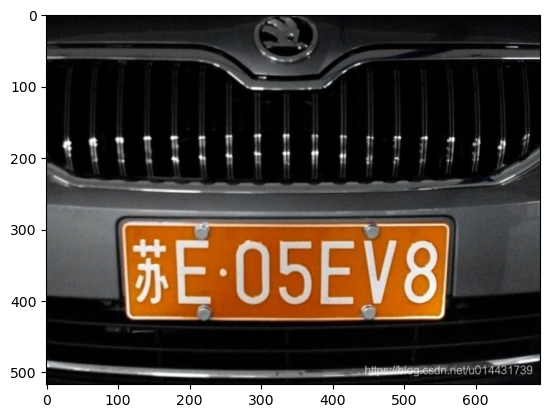

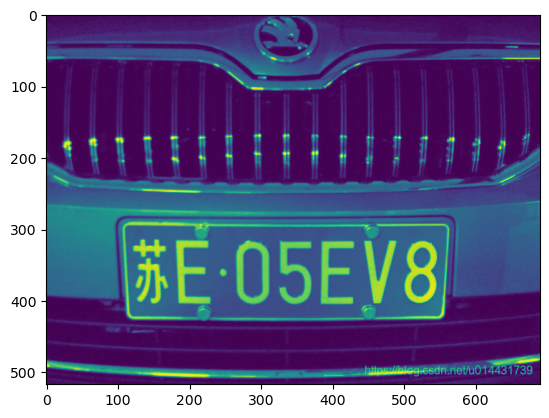

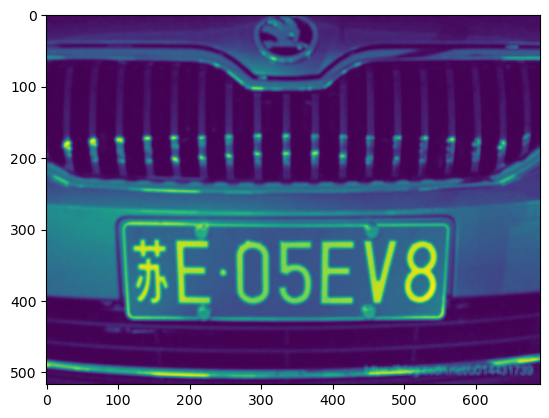

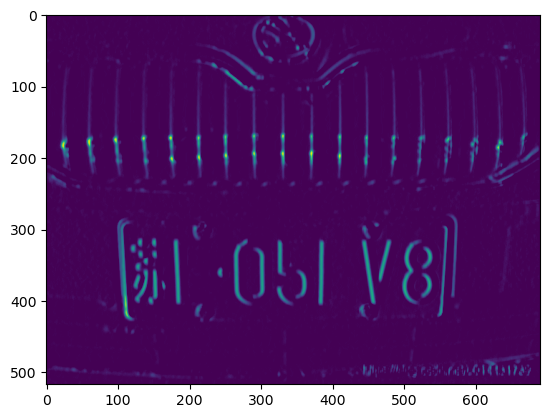

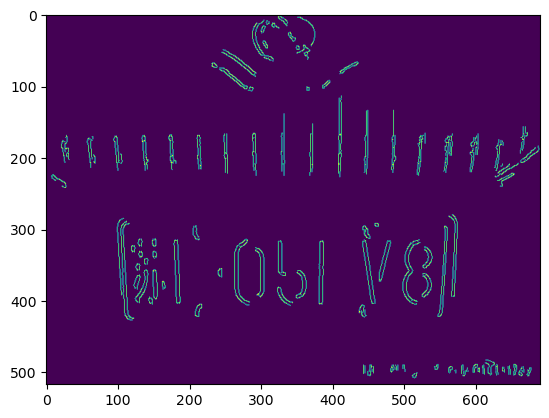

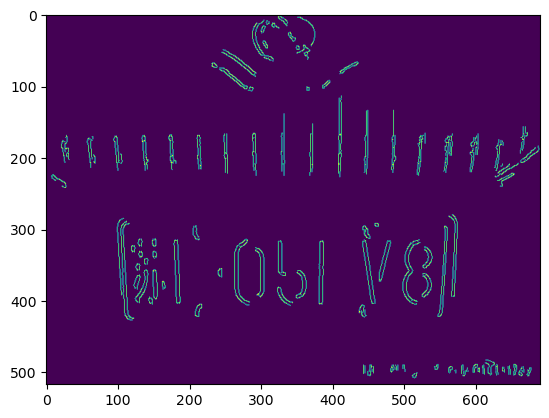

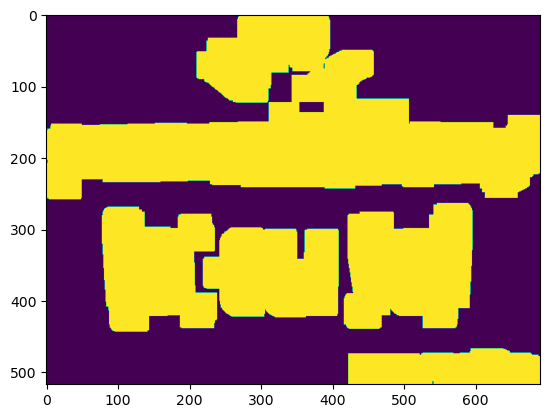

1


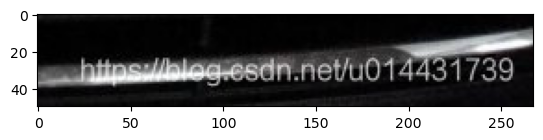

1


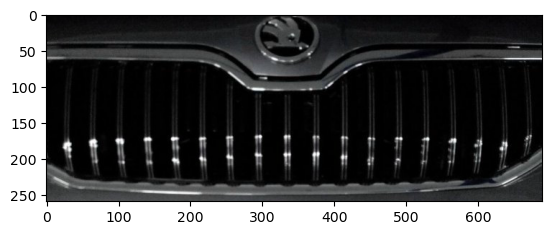

1


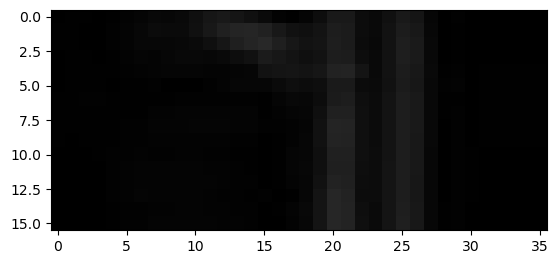

In [25]:
import cv2 as cv
import matplotlib.pyplot as plt

# 读取彩色的图片
img = cv.imread("dataset/Blue/9.jpg")
plt.imshow(img)
plt.show()
# 转换为灰度图
img1 = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img1)
plt.show()
# 用Sobel进行边缘检测
# # 高斯模糊
img2 = cv.GaussianBlur(img1,(5,5),10)
plt.imshow(img2)
plt.show()
# Laplacian进行边缘检测
img3 = cv.Sobel(img2,cv.CV_8U,1,0,ksize=1)
plt.imshow(img3)
plt.show()
img4 = cv.Canny(img3,40,100)
plt.imshow(img4)
plt.show()
# 进行二值化处理
i,img5 = cv.threshold(img4,0,255,cv.THRESH_BINARY)
plt.imshow(img5)
plt.show()
# 可以侵蚀和扩张
kernel = cv.getStructuringElement(cv.MORPH_RECT,(43,33))
img6 = cv.dilate(img5,kernel)
plt.imshow(img6)
plt.show()
# # 循环找到所有的轮廓
i,j = cv.findContours(img6,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
result = None
for i1 in i:
    x,y,w,h = cv.boundingRect(i1)
    if w>2*h:
        print(1)
        plt.imshow(img[y:y+h,x:x+w])
        plt.show()
        result = img[y:y+h,x:x+w]